# SCGEN:  Perturbation Prediction

In [1]:
import logging
import os

import scanpy as sc
import scgen

Global seed set to 0
c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\pytorch_lightning\utilities\warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\pytorch_lightning\utilities\warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


### Loading Train Data

In [2]:
train = sc.read(os.path.join('..', 'data','train_kang.h5ad'),
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')
train

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

Let's remove stimulated CD4T cells from both the training set. This is just for the sake of this notebook, in practice, you do not need to do this step, just pass the train data

In [12]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
train_new = train_new.copy()

### Preprocessing Data

In [13]:
scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

## Creating and Saving the model¶

In [18]:
model = scgen.SCGEN(train_new)
model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

## Training the Model

In [19]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=False,
    early_stopping_patience=25
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [1:31:20<00:00, 58.12s/it, loss=70.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:31:20<00:00, 54.81s/it, loss=70.2, v_num=1]


In [20]:
model.save("../saved_models/model_perturbation_prediction_trained.pt")

In [21]:
model_1 = scgen.SCGEN.load("../saved_models/model_perturbation_prediction_trained.pt", adata=train_new)
model_1

INFO     File ../saved_models/model_perturbation_prediction_trained.pt\model.pt already downloaded                 


SCGEN Model with the following params: 
n_hidden: 800, n_latent: 100, n_layers: 2, dropout_rate: 0.2
Training status: Trained

### Latent Space

In [22]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


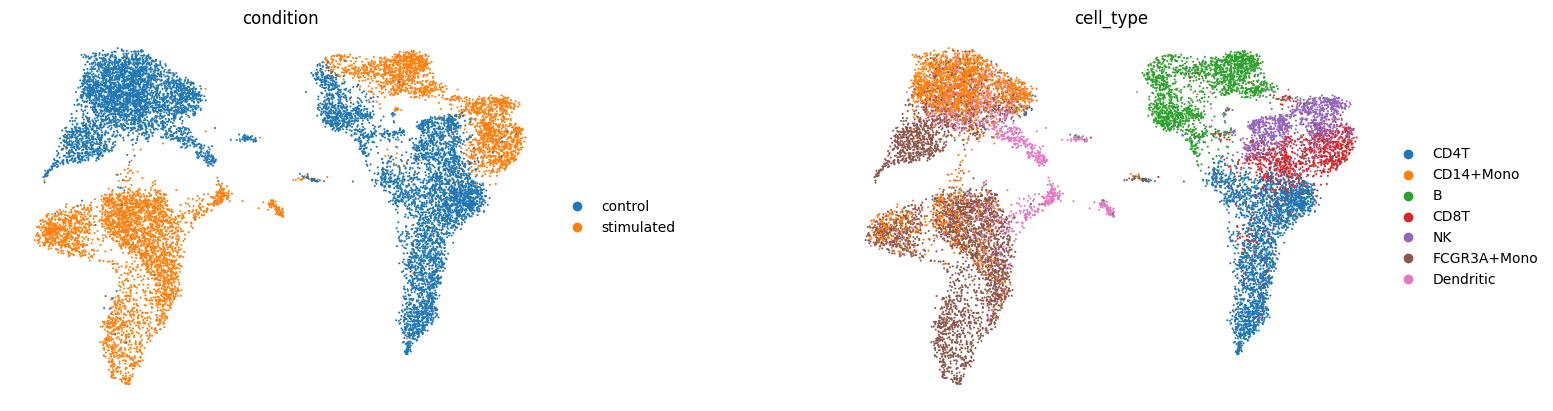

In [23]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

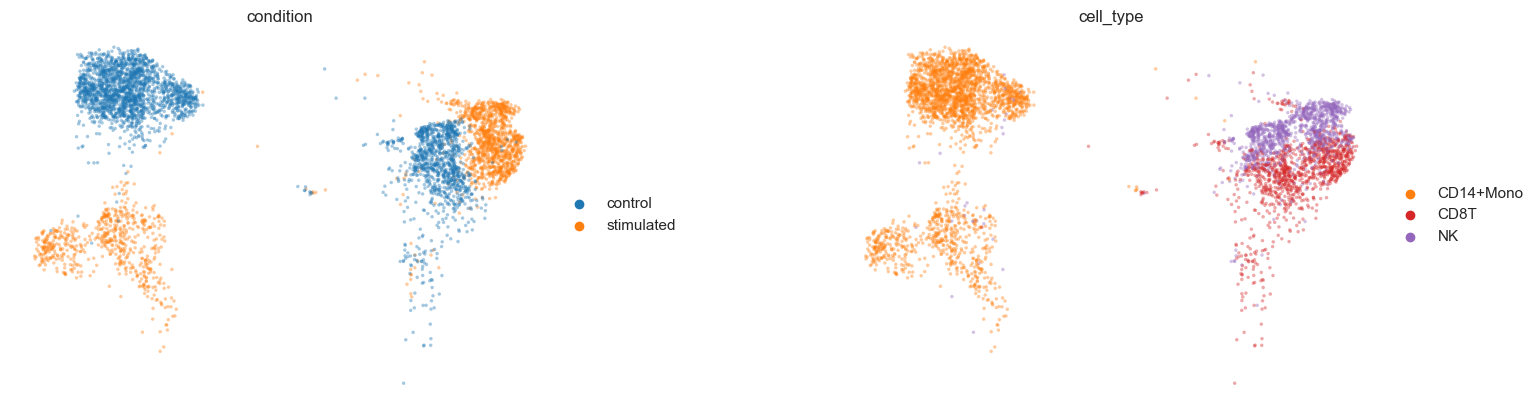

In [45]:
from time import time

cell_type = 'Dendritic'
sc.pl.umap(latent_adata[latent_adata.obs['cell_type'].isin(['CD8T', 'NK', 'CD14+Mono'])], color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save=f'latentspace_{int(time())}.pdf', alpha=0.4
           )

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [24]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

INFO     Received view of anndata, making copy.                                                                    


c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition", obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition¶


#### Extracting both control and real stimulated CD4T cells from our dataset

In [25]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

Merging predicted cells with real ones

In [26]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


### Embedding all real and predicted cells in one PCA plot¶

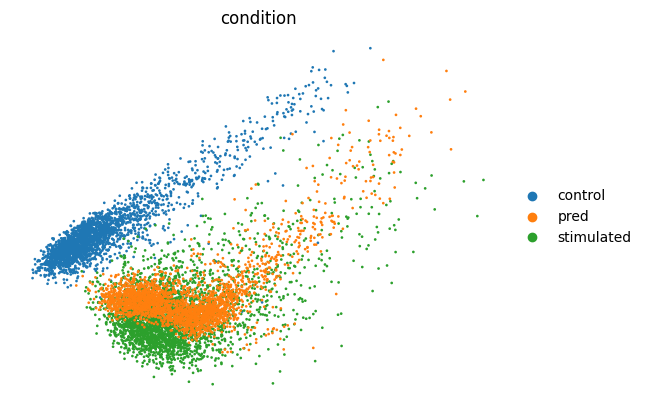

In [27]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

## Mean correlation plot¶

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [28]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [29]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


In [30]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

You can also pass a list of differentially epxressed genes to compute correlation based on them

In [31]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

### Violin plot for a specific gene¶


Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

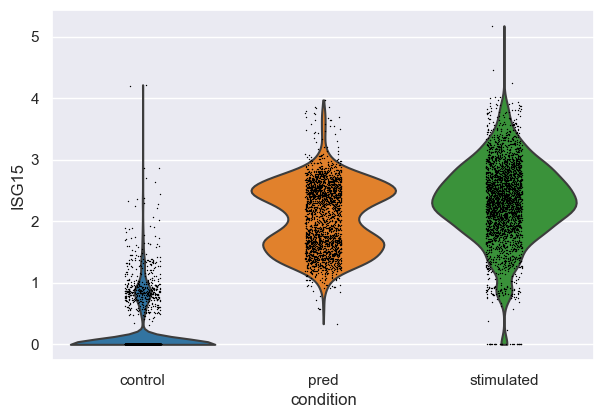

In [32]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")